# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# our own modules
import linear_emulator
import data_PD2013
import lya_theory
import fit_linP
import likelihood

### Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z

In [3]:
# load P1D emulator
emu=linear_emulator.LinearEmulator(verbose=False)

setup interpolator for coefficient 0
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-1.18323575]
setup interpolator for coefficient 1
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.6323589]
setup interpolator for coefficient 2
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.29370814]
setup interpolator for coefficient 3
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.1279153]
setup interpolator for coefficient 4
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.01945575]


In [4]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=True)

Note: redshifts have been re-sorted (earliest first)
use default mean flux model
use default thermal model


In [5]:
# specify free parameters in likelihood
free_parameters=['ln_tau_0','ln_tau_1','Delta2_star','n_star']

In [6]:
like=likelihood.Likelihood(data=data,theory=theory,free_parameters=free_parameters,verbose=True)

got parameters
g_star = 0.9677508579459803
f_star = 0.98136955784
Delta2_star = 0.360175905286
n_star = -2.29933566726
alpha_star = -0.216527037121
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.21034037198
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = 0.0
likelihood setup with 4 free parameters
4 free parameters


In [7]:
for p in like.free_params:
    print(p.name,p.value)

Delta2_star 0.360175905286
n_star -2.29933566726
ln_tau_0 -0.794580172414
ln_tau_1 3.18


In [8]:
like.go_silent()

### Setup MCMC to call this function

In [9]:
def log_prob(values,like,verbose=False):
    test_log_prob=like.log_prob(values=values)
    if np.isnan(test_log_prob):
        if verbose:
            print('parameter values outside hull',values)
        return -np.inf
    return test_log_prob

In [10]:
def setup_walkers(ndim,nwalkers,like,verbose=False):
    print('setup %d walkers with %d dimensions'%(nwalkers,ndim))
    p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
    # make sure that all walkers are within the convex hull
    for iw in range(nwalkers):
        walker=p0[iw]
        if verbose: print(iw,'walker',walker)
        test=log_prob(walker,like)
        while (test == -np.inf):
            if verbose: print(iw,'bad walker',walker)
            walker = np.random.rand(ndim)
            if verbose: print(iw,'try walker',walker)
            test=log_prob(walker,like)
        if verbose: print(iw,'good walker',walker,' log_prob=',test)
        p0[iw]=walker
    return p0

In [11]:
# for now we'll have only three dimensions (mean flux, temperature, gamma)
ndim=len(like.free_params)
# setup initial walkers
nwalkers = 40

In [12]:
p0=setup_walkers(ndim,nwalkers,like)

setup 40 walkers with 4 dimensions


In [13]:
# setup sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like])

In [14]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 100)
print('finished burn-in at',pos[0],prob[0])

finished burn-in at [ 0.45735856  0.12422731  0.63633436  0.65789146] -1898.93904851


In [15]:
# reset and run actual chains
sampler.reset()
nsteps=1000
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 100 == 0:
        print(i,result[0][0])

0 [ 0.45735856  0.12422731  0.63633436  0.65789146]
100 [ 0.39511109  0.17612864  0.67162366  0.64767773]
200 [ 0.41735599  0.130466    0.65134158  0.61836193]
300 [ 0.43489941  0.12822954  0.64414868  0.66166559]
400 [ 0.41168199  0.16756802  0.6675891   0.65410695]
500 [ 0.43237979  0.1616918   0.65954986  0.65207844]
600 [ 0.38088894  0.1624728   0.66073703  0.66245533]
700 [ 0.40085023  0.19192315  0.6692579   0.65658725]
800 [ 0.47908769  0.15053977  0.65053379  0.64605391]
900 [ 0.42472928  0.16309888  0.66259132  0.65572544]


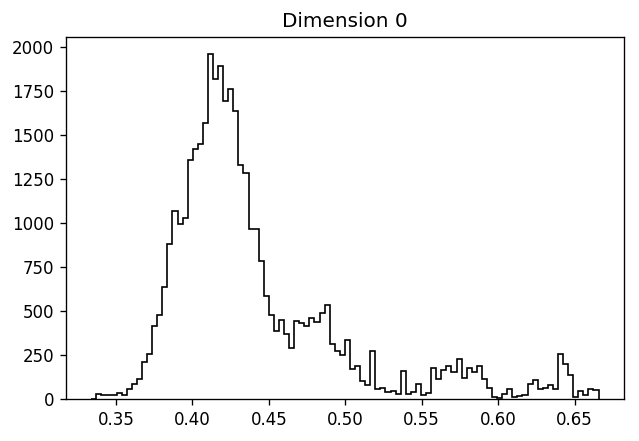

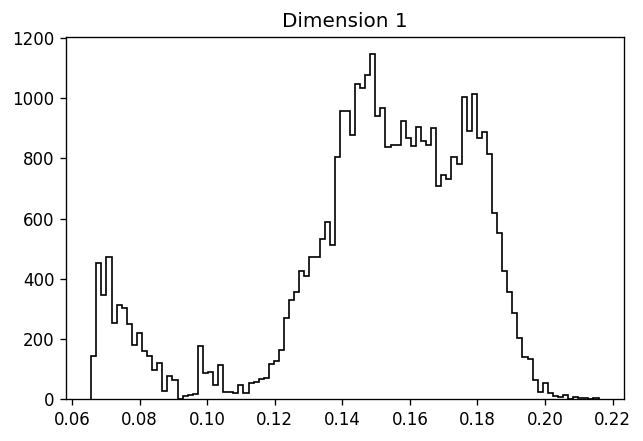

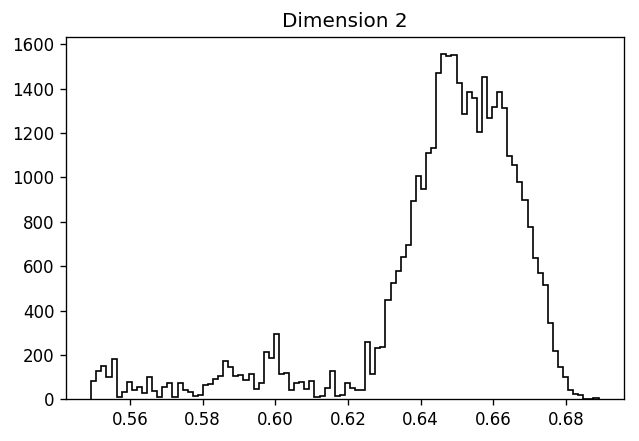

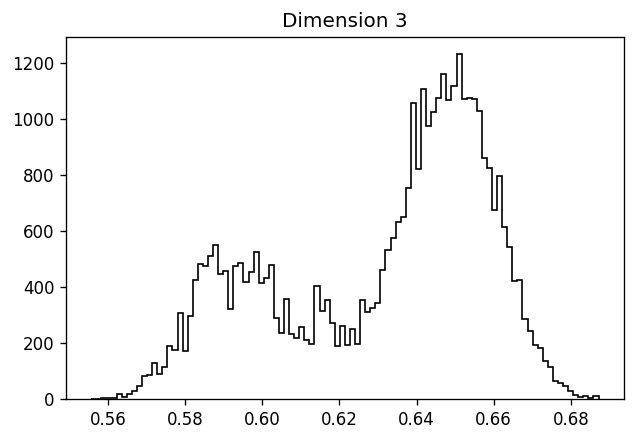

In [16]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

In [17]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.370


### Use likelihood object to make several useful plots

In [18]:
# get mean of chain
mcmc_mean=np.mean(sampler.flatchain,axis=0)
print('mean point',mcmc_mean)

mean point [ 0.44200509  0.14993034  0.64603491  0.63146445]


In [19]:
like.update_parameters(mcmc_mean)

In [20]:
for p in like.free_params:
    print(p.name,p.value)

Delta2_star 0.316300764205
n_star -2.33500696572
ln_tau_0 -0.876982547045
ln_tau_1 4.26292889506


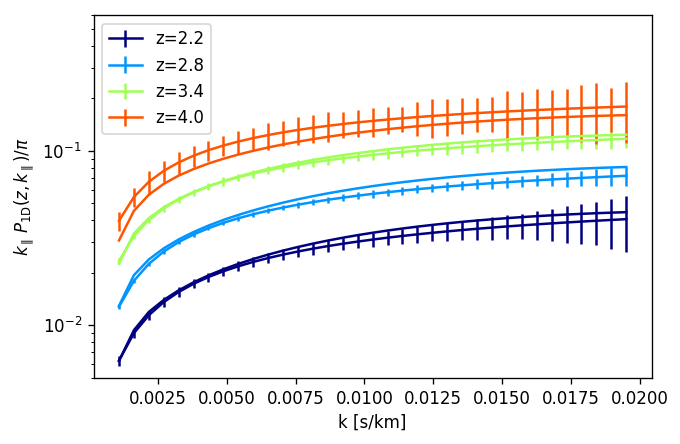

In [22]:
like.plot_p1d()

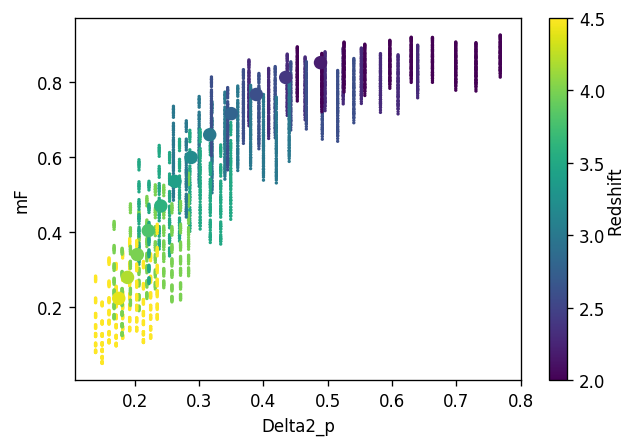

In [26]:
like.overplot_emulator_calls('Delta2_p','mF')

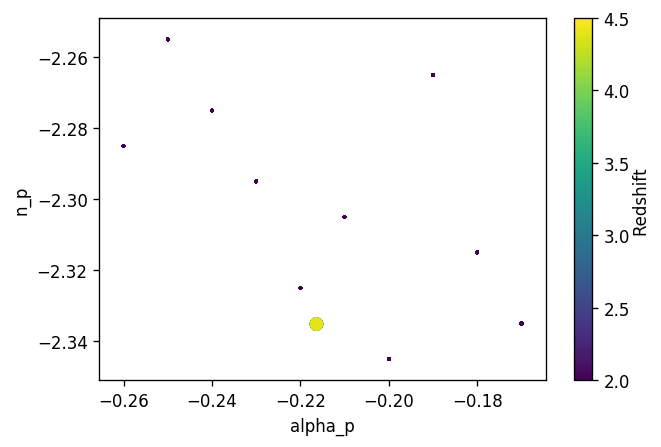

In [27]:
like.overplot_emulator_calls('alpha_p','n_p')